In [ ]:
!pip install tensorflow version==2.10
from importlib import import_module

import tensorflow as tf
print(tf.__version__)

from keras.api._v2 import keras as KerasAPI
# using the import module import the tensorflow.keras module'
# and typehint that the type is KerasAPI module
keras: KerasAPI = import_module("tensorflow.keras")

from keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement version==2.10 (from versions: 0.1.0, 0.1.1)
ERROR: No matching distribution found for version==2.10
2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import fasttext

# bio_model = fasttext.load_model('./BioWordVec_PubMed_MIMICIII_d200.bin')

In [ ]:
def col4_preprocessing(path, save_path=None, ci_words=('Clinical information', 'CI', 'History', 'C.I', '* CI')):
    import numpy as np
    import pandas as pd

    df = pd.read_csv(path, header=0, encoding='euc-kr')

    ci_ls, finding, new_finding, new_con = list(), list(), list(), list()
    findings = df.iloc[:,0].str.replace('\n','\r').str.split('\r')
    null_val = 'None'
    val_point = 0

    # ci, finding split
    for idx, c in enumerate(findings):
        val_point = 0
        if isinstance(c, list):
            for i, s in enumerate(c):
                ci = s.startswith(ci_words) # ci_words로 시작하는 문장을 CI로 분류
                if ci == True and val_point == 0:
                    ci_ls.append(s)
                    c.remove(s)
                    if '' in c:
                        finding.append(c)
                    else:
                        finding.append(null_val)
                    val_point += 1
                else:
                    pass
                
            if val_point == 0:
                ci_ls.append(null_val)
                finding.append(c)
  
        else:
            ci_ls.append(null_val)
            finding.append(null_val)

    # finding 전처리
    for ls in finding:
        if isinstance(ls, list) == False:
            new_finding.append(null_val)
            continue
        else:
            find = ''
            for val in ls:
                if len(val) > 2:
                    find = find + ' ' + val
                else:
                    pass
        
        if find is not '':
            new_finding.append(find)
        else:
            new_finding.append(null_val)

    # conclusion 전처리
    cons = df.iloc[:,1].str.replace('\n','\r').str.split('\r')
    for ls in cons:
        if isinstance(ls, list):
            con = ''
            for val in ls:
                if len(val) > 1:
                    con = con + ' ' + val
                else:
                    pass
            new_con.append(con)
    
        else:
            new_con.append(null_val)

    # 4 columns
    new_df = pd.DataFrame(
        {'CI':ci_ls, 'Findings':new_finding, 'Conclusion':new_con, 'Label':df['AcuteInfarction'].tolist()})
    
    # save to csv
    if save_path:
        new_df.to_csv(save_path, encoding="euc-kr", index=False)

    return new_df

In [ ]:
import pandas as pd
import numpy as np

df = col4_preprocessing("/content/drive/MyDrive/AI_contest/train_set_no_duplicates.csv")
display(df)

,CI,Findings,Conclusion,Label
0,Clinical information : 두부외상 후 후유증 평가,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",1. Encephalomalacic change in both frontal lo...,0
1,Clinical information : lung cancer,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",1. No change of focal enhancing lesion in lef...,0
2,Clinical information : Multiple Sclerosis,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",No significant interval change of abnormal hy...,0
3,Clinical information : patient with DLBCL.,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",1. Decreased extent of enhancing mass in the ...,0
4,Clinical information : Transient cerebral isch...,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...","1. Acute infarctions at right BG, right F-P-T...",1
...,...,...,...,...
5331,Clinical information : s/p Removal of vestibul...,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",No evidence of remnant mass or remarkable pos...,0
5332,"CI, headache of sudden onset (known UIA).","Axial T1WI, sagittal T1WI, axial T2WI, axial ...",1. No evidence of acute infarctions. 2. Encep...,0
5333,Clinical information : patient with DLBCL.,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",1. Increased size of homogeneous enhancing ma...,0
5334,Clinical information : Lung cancer patient 임.,"Axial T1WI, sagittal T1WI, axial T2WI, axial ...",No evidence of intracranial metastasis.,0


In [ ]:
df_conc = df['Conclusion'].astype('str').apply(lambda x : x.lower())

In [ ]:
df_conc.replace(['lobe.'], ['lobe'], regex=True, inplace=True)
df_conc.replace(['microangiopathy.'], ['microangiopathy'], regex=True, inplace=True)
df_conc.replace(['rt'], ['right'], regex=True, inplace=True)
df_conc.replace(['lt'], ['left'], regex=True, inplace=True)

In [ ]:
df_find = df['Findings']
# df_find.replace(['\r\n\n'], ['None'], regex=True, inplace=True)
df_find = df_find.astype('str').apply(lambda x : x.lower())

In [ ]:
df_ci = df['CI']
df_ci = df_ci.astype('str').apply(lambda x : x.lower())

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from string import punctuation

nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(punctuation))
stop_words = stop_words.union(('2.', '1.', '3.', '4.', '5.', '--'))
tokenizer = TreebankWordTokenizer()

tokens_find = []
tokens_conc = []
tokens_ci = []

for i in range(len(df)): # length of the dataframe
    sent1 = tokenizer.tokenize(str(df_find[i]))
    for w1 in sent1:
        if w1 not in stop_words:
            tokens_find.append(w1)
            
    sent2 = tokenizer.tokenize(str(df_conc[i]))
    for w2 in sent2:
        if w2 not in stop_words:
            tokens_conc.append(w2)

    sent3 = tokenizer.tokenize(str(df_ci[i]))
    for w3 in sent3:
        if w3 not in stop_words:
            tokens_ci.append(w3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
en_find = nltk.Text(tokens_find)
en_conc = nltk.Text(tokens_conc)
en_ci = nltk.Text(tokens_ci)
print(len(en_conc.tokens)) # returns number of unique tokens
print(len(set(en_conc.tokens)))
print(len(set(en_ci.tokens)))
en_conc.vocab()                  # returns frequency distribution

78151
4016
1730


FreqDist({'left': 3975, 'right': 3959, 'lobe': 1841, 'stenosis': 1555, 'frontal': 1294, 'microangiopathy': 1190, 'infarction': 1186, 'change': 1185, 'brain': 1183, 'focal': 1147, ...})

In [ ]:
target = df.pop('Label')

In [ ]:
target.value_counts()

0    4733
1     603
Name: Label, dtype: int64

In [ ]:
df_ = np.stack((pd.DataFrame(df_find), pd.DataFrame(df_conc), pd.DataFrame(df_ci)), axis=-1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_, target, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False) #~ 0.25 x 0.8 = 0.2

In [ ]:
x_train_find = X_train[...,0,0]
x_test_find = X_test[...,0,0]
x_val_find = X_val[...,0,0]

x_train_conc = X_train[...,0,1]
x_test_conc = X_test[...,0,1]
x_val_conc = X_val[...,0,1]

x_train_ci = X_train[...,0,1]
x_test_ci = X_test[...,0,1]
x_val_ci = X_val[...,0,1]

In [ ]:
train_ds_find = tf.data.Dataset.from_tensor_slices((x_train_find, y_train))
train_ds_conc = tf.data.Dataset.from_tensor_slices((x_train_conc, y_train))
train_ds_ci = tf.data.Dataset.from_tensor_slices((x_train_ci, y_train))

val_ds_find = tf.data.Dataset.from_tensor_slices((x_val_find, y_val))
val_ds_conc = tf.data.Dataset.from_tensor_slices((x_val_conc, y_val))
val_ds_ci = tf.data.Dataset.from_tensor_slices((x_val_ci, y_val))

test_ds_find = tf.data.Dataset.from_tensor_slices((x_test_find, y_test))
test_ds_conc = tf.data.Dataset.from_tensor_slices((x_test_conc, y_test))
test_ds_ci = tf.data.Dataset.from_tensor_slices((x_test_ci, y_test))

In [ ]:
import tensorflow as tf
from keras import layers

tf.config.run_functions_eagerly(True)
def custom_split_fn(string_tensor):
    # print(string_tensor)
    if tf.is_tensor(string_tensor):
        string_numpy = string_tensor.numpy().decode()
    else:
        string_numpy = string_tensor.decode()
    string_split_lst = [w for w in tokenizer.tokenize(string_numpy) if w not in stop_words]
    return tf.ragged.constant(string_split_lst)

In [ ]:
max_tokens, max_length = 17000, 600

In [ ]:
find_text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
    ngrams=2,
    split=custom_split_fn
)

# text_only_train_ds_find = train_ds_find.map(lambda x, y: x)
# find_text_vectorization.adapt(text_only_train_ds_find)

In [ ]:
find_text_vectorization

In [ ]:
max_length = 600
max_tokens = 16703
tf.data.experimental.enable_debug_mode()

find_text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
    ngrams=2,
    split=custom_split_fn
)
conc_text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
    ngrams=2,
    split=custom_split_fn
)
ci_text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=None,
    ngrams=2,
    split=custom_split_fn
)

text_only_train_ds_find = train_ds_find.map(lambda x, y: x)
find_text_vectorization.adapt(text_only_train_ds_find)
text_only_train_ds_conc = train_ds_conc.map(lambda x, y: x)
conc_text_vectorization.adapt(text_only_train_ds_conc)
text_only_train_ds_ci = train_ds_ci.map(lambda x, y: x)
ci_text_vectorization.adapt(text_only_train_ds_ci)

In [ ]:
train_DS_find = train_ds_find.map(
    lambda x, y: (tf.numpy_function(find_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
train_DS_conc = train_ds_conc.map(
    lambda x, y: (tf.numpy_function(conc_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
train_DS_ci = train_ds_ci.map(
    lambda x, y: (tf.numpy_function(ci_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
train_DS_label = train_ds_find.map(
    lambda x, y: y)

val_DS_find = val_ds_find.map(
    lambda x, y: (tf.numpy_function(find_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
val_DS_conc = val_ds_conc.map(
    lambda x, y: (tf.numpy_function(conc_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
val_DS_ci = val_ds_ci.map(
    lambda x, y: (tf.numpy_function(ci_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
val_DS_label = val_ds_find.map(
    lambda x, y: y)

test_DS_find = test_ds_find.map(
    lambda x, y: (tf.numpy_function(find_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
test_DS_conc = test_ds_conc.map(
    lambda x, y: (tf.numpy_function(conc_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
test_DS_ci = test_ds_ci.map(
    lambda x, y: (tf.numpy_function(ci_text_vectorization, [x], tf.int64)),
    num_parallel_calls=4)
test_DS_label = test_ds_find.map(
    lambda x, y: y)

### 여기까지 실행 잘 되는 거 확인
---

In [ ]:
train_DS = tf.data.Dataset.zip(((train_DS_find, train_DS_conc), train_DS_label))
val_DS = tf.data.Dataset.zip(((val_DS_find, val_DS_conc), val_DS_label))
test_DS = tf.data.Dataset.zip(((test_DS_find, test_DS_conc), test_DS_label))

In [ ]:
embedding_dim = 200

find_vocabulary = find_text_vectorization.get_vocabulary()
find_word_index = dict(zip(find_vocabulary, range(len(find_vocabulary))))

conc_vocabulary = conc_text_vectorization.get_vocabulary()
conc_word_index = dict(zip(conc_vocabulary, range(len(conc_vocabulary))))

find_embedding_matrix = np.zeros((max_tokens, embedding_dim))
conc_embedding_matrix = np.zeros((max_tokens, embedding_dim))

for word, i in find_word_index.items():
     embedding_vector = bio_model.get_word_vector(word)
     find_embedding_matrix[i] = embedding_vector
     
for word, i in conc_word_index.items():
     embedding_vector = bio_model.get_word_vector(word)
     conc_embedding_matrix[i] = embedding_vector

In [ ]:
find_pre_embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(find_embedding_matrix),
    trainable=False,
    mask_zero=True
)

conc_pre_embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(conc_embedding_matrix),
    trainable=False,
    mask_zero=True
)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
weights = {i : weights[i].round(2) for i in range(2)}
weights

{0: 0.56, 1: 4.43}

In [ ]:
inputs_1 = keras.Input(shape=(None,), dtype='int64', name='Findings')
inputs_2 = keras.Input(shape=(None,), dtype='int64', name='Conclusion')

find_embedded = find_pre_embedding_layer
conc_embedded = conc_pre_embedding_layer
bi_gru = layers.Bidirectional(layers.GRU(128))
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25))(embedded) #todo: avoid overfitting

output_1 = find_embedded(inputs_1)
output_1 = bi_gru(output_1)

output_2 = conc_embedded(inputs_2)
output_2 = bi_gru(output_2)


semi_output = layers.Concatenate()([output_1, output_2])

x = layers.Dropout(0.3)(semi_output)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model([inputs_1, inputs_2], outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Findings (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 Conclusion (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    3340600     ['Findings[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 200)    3340600     ['Conclusion[0][0]']             
                                                                                            

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("bi-GRU_2col.keras",
                                    save_best_only=True),
    keras.callbacks.TensorBoard()
]

model.fit(train_DS.cache().shuffle(10000).batch(32),
          validation_data=val_DS.cache().batch(32),
          epochs=30,
          callbacks=callbacks,
          class_weight=weights)

Epoch 1/30


2022-10-29 02:41:42.764806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 580 of 10000
2022-10-29 02:41:52.760467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1152 of 10000
2022-10-29 02:42:02.767086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1694 of 10000
2022-10-29 02:42:12.771988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2259 of 10000
2022-10-29 02:42:22.770418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2790 of 10000
2022-10-29 02:42:30.572711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-29 02:42:31.475449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 96/101 [===========================>..] - ETA: 3s - loss: 0.2866 - accuracy: 0.8763

2022-10-28 15:15:38.152105: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


34/34 [==============================] - 14s 283ms/step


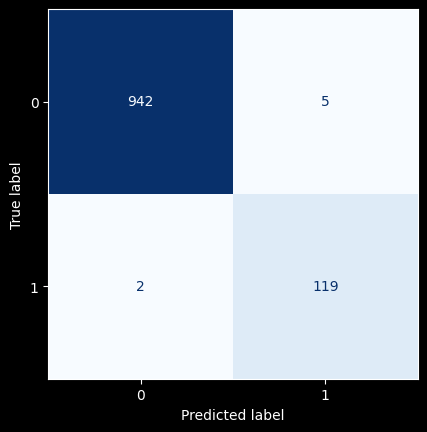

              precision    recall  f1-score   support

           0     0.9979    0.9947    0.9963       947
           1     0.9597    0.9835    0.9714       121

    accuracy                         0.9934      1068
   macro avg     0.9788    0.9891    0.9839      1068
weighted avg     0.9936    0.9934    0.9935      1068

0.9890956216673794


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model = keras.models.load_model("test_with_preprocessed_128.keras")
prediction = model.predict(test_DS)
prediction[prediction>=0.5] = 1
prediction[prediction<0.5] = 0

cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.show()

print(classification_report(y_test, prediction, digits=4))
print(roc_auc_score(y_test, prediction))

In [ ]:
prediction = np.squeeze(prediction)

In [ ]:
np.where(prediction!=y_test)

(array([683, 694, 763, 814, 853, 896, 953]),)

In [ ]:
idx = 953

print(X_test.iloc[idx])
print(y_test.iloc[idx])
print(prediction[idx])

1. acute pontine infarction, left.
2. old infarctions in both frontal lobe, both bg.
3. diffuse brain atrophy.
4. left va occlusion.


0
1.0
